# DL Models Comparison

Comparison of all 10 trained DL models:
- Load all models
- Evaluate on test set
- Create visualizations
- Generate comparison report

In [6]:
#!pip install seaborn 

In [7]:
import sys
from pathlib import Path
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
from tqdm import tqdm

# Determine project root (parent of notebooks directory)
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name in ['notebooks', 'b-p_first_experiments'] else Path.cwd()
sys.path.insert(0, str(PROJECT_ROOT))

# Import all models
from models.spectrogram.resnet_spectrogram import resnet18_spectrogram
from models.spectrogram.vit_spectrogram import VisionTransformerSpectrogram
from models.hybrid.hybrid_cnn_mlp import HybridCNNMLP
from models.hybrid.multimodal_fusion import MultiModalFusion
from models.sequence.bilstm_attention import BiLSTMAttention
from models.sequence.transformer_sequence import TransformerSequence
from models.raw_audio.raw_audio_cnn import RawAudioCNN
from models.raw_audio.context_audio import ContextAudioModel
from models.specialized.formant_focused import FormantFocusedModel
from models.ensemble.stacking_ensemble import StackingEnsemble

from utils.training_utils import evaluate_model
from utils.data_loader import load_data, create_dataloaders

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using MPS device")
else:
    device = torch.device("cpu")

OUTPUT_DIR = PROJECT_ROOT / 'artifacts' / 'b-p_dl_models'
COMPARISON_DIR = OUTPUT_DIR / 'comparison'
COMPARISON_DIR.mkdir(parents=True, exist_ok=True)

# Load data
df, spectrograms_dict, feature_cols, feature_scaler, class_weights_dict = load_data(PROJECT_ROOT)
dataloaders = create_dataloaders(df, spectrograms_dict, feature_cols, feature_scaler, class_weights_dict, batch_size=64)

class_weights = torch.tensor([class_weights_dict.get('0', class_weights_dict.get(0, 1.0)), 
                              class_weights_dict.get('1', class_weights_dict.get(1, 1.0))], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

Using MPS device
Columns in df_phonemes: ['phoneme_id', 'utterance_id', 'phoneme', 'class', 'start_ms', 'end_ms', 'duration_ms', 'audio_path']
Columns in df_features: ['energy_rms', 'energy_rms_std', 'energy_zcr', 'energy_zcr_std', 'spectral_centroid', 'spectral_centroid_std', 'spectral_rolloff', 'spectral_rolloff_std', 'spectral_bandwidth', 'spectral_bandwidth_std', 'formant_f1', 'formant_f2', 'formant_f3', 'formant_f4', 'formant_f1_std', 'formant_f2_std', 'formant_f3_std', 'formant_f4_std', 'spectral_flatness', 'harmonic_noise_ratio', 'zcr_mean', 'energy_cv', 'phoneme_id', 'class', 'duration_ms', 'mfcc_mean_0', 'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 'mfcc_mean_8', 'mfcc_mean_9', 'mfcc_mean_10', 'mfcc_mean_11', 'mfcc_mean_12', 'mfcc_std_0', 'mfcc_std_1', 'mfcc_std_2', 'mfcc_std_3', 'mfcc_std_4', 'mfcc_std_5', 'mfcc_std_6', 'mfcc_std_7', 'mfcc_std_8', 'mfcc_std_9', 'mfcc_std_10', 'mfcc_std_11', 'mfcc_std_12', 'delta_mfcc

## Load All Models and Evaluate

In [8]:
# Model configurations
models_config = [
    {'name': 'Model 1: ResNet', 'path': OUTPUT_DIR / 'spectrogram_models' / 'resnet_spectrogram', 
     'loader': dataloaders['spectrogram'], 'model_class': resnet18_spectrogram, 'args': {'num_classes': 2}},
    {'name': 'Model 2: ViT', 'path': OUTPUT_DIR / 'spectrogram_models' / 'vit_spectrogram',
     'loader': dataloaders['spectrogram'], 'model_class': VisionTransformerSpectrogram, 
     'args': {'img_size': (128, 7), 'patch_size': (16, 1), 'embed_dim': 128, 'depth': 6, 'num_heads': 8, 'num_classes': 2}},
    {'name': 'Model 3: Hybrid CNN+MLP', 'path': OUTPUT_DIR / 'hybrid_models' / 'hybrid_cnn_mlp',
     'loader': dataloaders['hybrid'], 'model_class': HybridCNNMLP, 'args': {'n_features': len(feature_cols), 'num_classes': 2}},
    {'name': 'Model 4: Multi-modal Fusion', 'path': OUTPUT_DIR / 'hybrid_models' / 'multimodal_fusion',
     'loader': dataloaders['hybrid'], 'model_class': MultiModalFusion, 
     'args': {'n_features': len(feature_cols), 'audio_length': 3200, 'num_classes': 2, 'fusion_type': 'late'}},
    {'name': 'Model 5: BiLSTM+Attention', 'path': OUTPUT_DIR / 'sequence_models' / 'bilstm_attention',
     'loader': dataloaders['sequence'], 'model_class': BiLSTMAttention, 
     'args': {'input_dim': 128, 'hidden_dim': 64, 'num_layers': 2, 'num_classes': 2}},
    {'name': 'Model 6: Transformer Sequence', 'path': OUTPUT_DIR / 'sequence_models' / 'transformer_sequence',
     'loader': dataloaders['sequence'], 'model_class': TransformerSequence,
     'args': {'input_dim': 128, 'd_model': 128, 'nhead': 8, 'num_layers': 4, 'num_classes': 2}},
    {'name': 'Model 7: Raw Audio CNN', 'path': OUTPUT_DIR / 'raw_audio_models' / 'raw_audio_cnn',
     'loader': dataloaders['raw_audio'], 'model_class': RawAudioCNN, 'args': {'input_length': 3200, 'num_classes': 2}},
    {'name': 'Model 8: Context Audio', 'path': OUTPUT_DIR / 'raw_audio_models' / 'context_audio',
     'loader': dataloaders['context_audio'], 'model_class': ContextAudioModel, 'args': {'audio_length': 3200, 'num_classes': 2}},
    {'name': 'Model 9: Formant-focused', 'path': OUTPUT_DIR / 'specialized_models' / 'formant_focused',
     'loader': dataloaders['feature'], 'model_class': FormantFocusedModel, 'args': {'n_features': len(feature_cols), 'num_classes': 2}}
]

# Load and evaluate all models
all_results = []
all_test_metrics = {}

for config in tqdm(models_config, desc="Loading models"):
    try:
        # Load model
        model = config['model_class'](**config['args']).to(device)
        checkpoint = torch.load(config['path'] / 'best_model.pt')
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Special handling for formant model
        if 'Formant' in config['name']:
            model.set_formant_indices(feature_cols, ['formant_f1', 'formant_f2', 'formant_f3'])
        
        # Evaluate
        test_loader = config['loader']['test']
        metrics, preds, labels, probs = evaluate_model(model, test_loader, criterion, device)
        
        metrics['model_name'] = config['name']
        metrics['model_path'] = str(config['path'])
        all_results.append(metrics)
        all_test_metrics[config['name']] = {
            'metrics': metrics,
            'predictions': preds,
            'labels': labels,
            'probabilities': probs
        }
        
        print(f"{config['name']}: Acc={metrics['accuracy']:.4f}, F1={metrics['f1']:.4f}, ROC-AUC={metrics['roc_auc']:.4f}")
    except Exception as e:
        print(f"Error loading {config['name']}: {e}")
        continue

# Create results DataFrame
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('accuracy', ascending=False)

print(f"\n{'='*80}")
print("All Models Test Results (sorted by accuracy):")
print(f"{'='*80}")
print(results_df[['model_name', 'accuracy', 'f1', 'roc_auc', 'precision', 'recall']].to_string(index=False))

# Save results
results_df.to_csv(COMPARISON_DIR / 'comparison_table.csv', index=False)
print(f"\nResults saved to {COMPARISON_DIR / 'comparison_table.csv'}")

Loading models:  11%|█         | 1/9 [00:07<00:56,  7.12s/it]

Model 1: ResNet: Acc=0.9331, F1=0.9329, ROC-AUC=0.9760


Loading models:  22%|██▏       | 2/9 [00:10<00:32,  4.68s/it]

Model 2: ViT: Acc=0.9106, F1=0.9122, ROC-AUC=0.9691


Loading models:  33%|███▎      | 3/9 [00:11<00:19,  3.23s/it]

Model 3: Hybrid CNN+MLP: Acc=0.9478, F1=0.9478, ROC-AUC=0.9875


Error loading Model 4: Multi-modal Fusion: not enough values to unpack (expected 3, got 2)


Loading models:  56%|█████▌    | 5/9 [00:13<00:07,  1.88s/it]/Volumes/SSanDisk/SpeechRec-German/venv_pytorch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Model 5: BiLSTM+Attention: Acc=0.9385, F1=0.9389, ROC-AUC=0.9843


Loading models:  67%|██████▋   | 6/9 [00:15<00:05,  1.86s/it]

Model 6: Transformer Sequence: Acc=0.9477, F1=0.9479, ROC-AUC=0.9867


Loading models:  78%|███████▊  | 7/9 [00:24<00:08,  4.05s/it]

Model 7: Raw Audio CNN: Acc=0.9275, F1=0.9271, ROC-AUC=0.9742


Loading models:  89%|████████▉ | 8/9 [00:27<00:03,  3.84s/it]

Model 8: Context Audio: Acc=0.9269, F1=0.9268, ROC-AUC=0.9744


Loading models: 100%|██████████| 9/9 [00:28<00:00,  3.14s/it]

Model 9: Formant-focused: Acc=0.9400, F1=0.9403, ROC-AUC=0.9840

All Models Test Results (sorted by accuracy):
                   model_name  accuracy       f1  roc_auc  precision   recall
      Model 3: Hybrid CNN+MLP  0.947841 0.947836 0.987493   0.947832 0.947841
Model 6: Transformer Sequence  0.947654 0.947946 0.986741   0.948567 0.947654
     Model 9: Formant-focused  0.939989 0.940260 0.983978   0.940742 0.939989
    Model 5: BiLSTM+Attention  0.938493 0.938920 0.984263   0.939858 0.938493
              Model 1: ResNet  0.933072 0.932915 0.976018   0.932810 0.933072
       Model 7: Raw Audio CNN  0.927463 0.927146 0.974216   0.927004 0.927463
       Model 8: Context Audio  0.926902 0.926778 0.974361   0.926681 0.926902
                 Model 2: ViT  0.910638 0.912242 0.969102   0.917727 0.910638

Results saved to /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dl_models/comparison/comparison_table.csv


## Visualizations

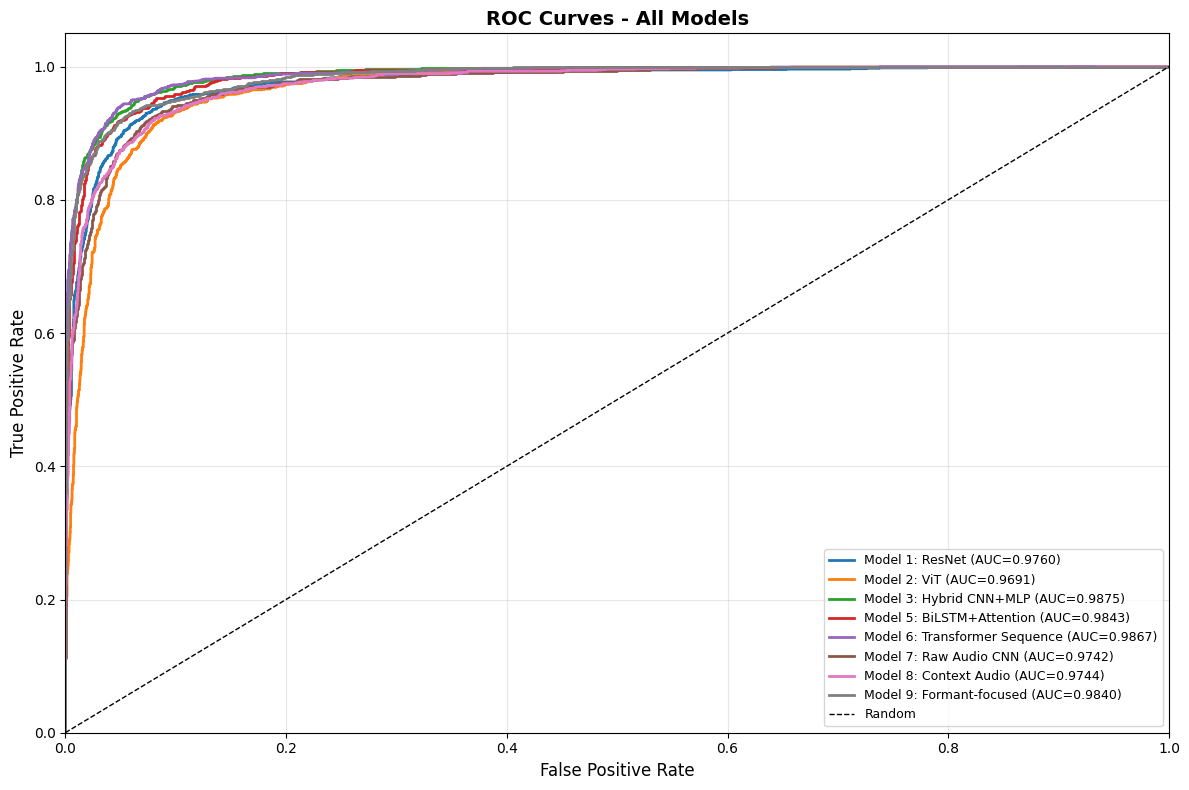

ROC curves saved.


In [9]:
# 1. ROC Curves
plt.figure(figsize=(12, 8))
for name, data in all_test_metrics.items():
    fpr, tpr, _ = roc_curve(data['labels'], np.array(data['probabilities'])[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.4f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(COMPARISON_DIR / 'roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("ROC curves saved.")

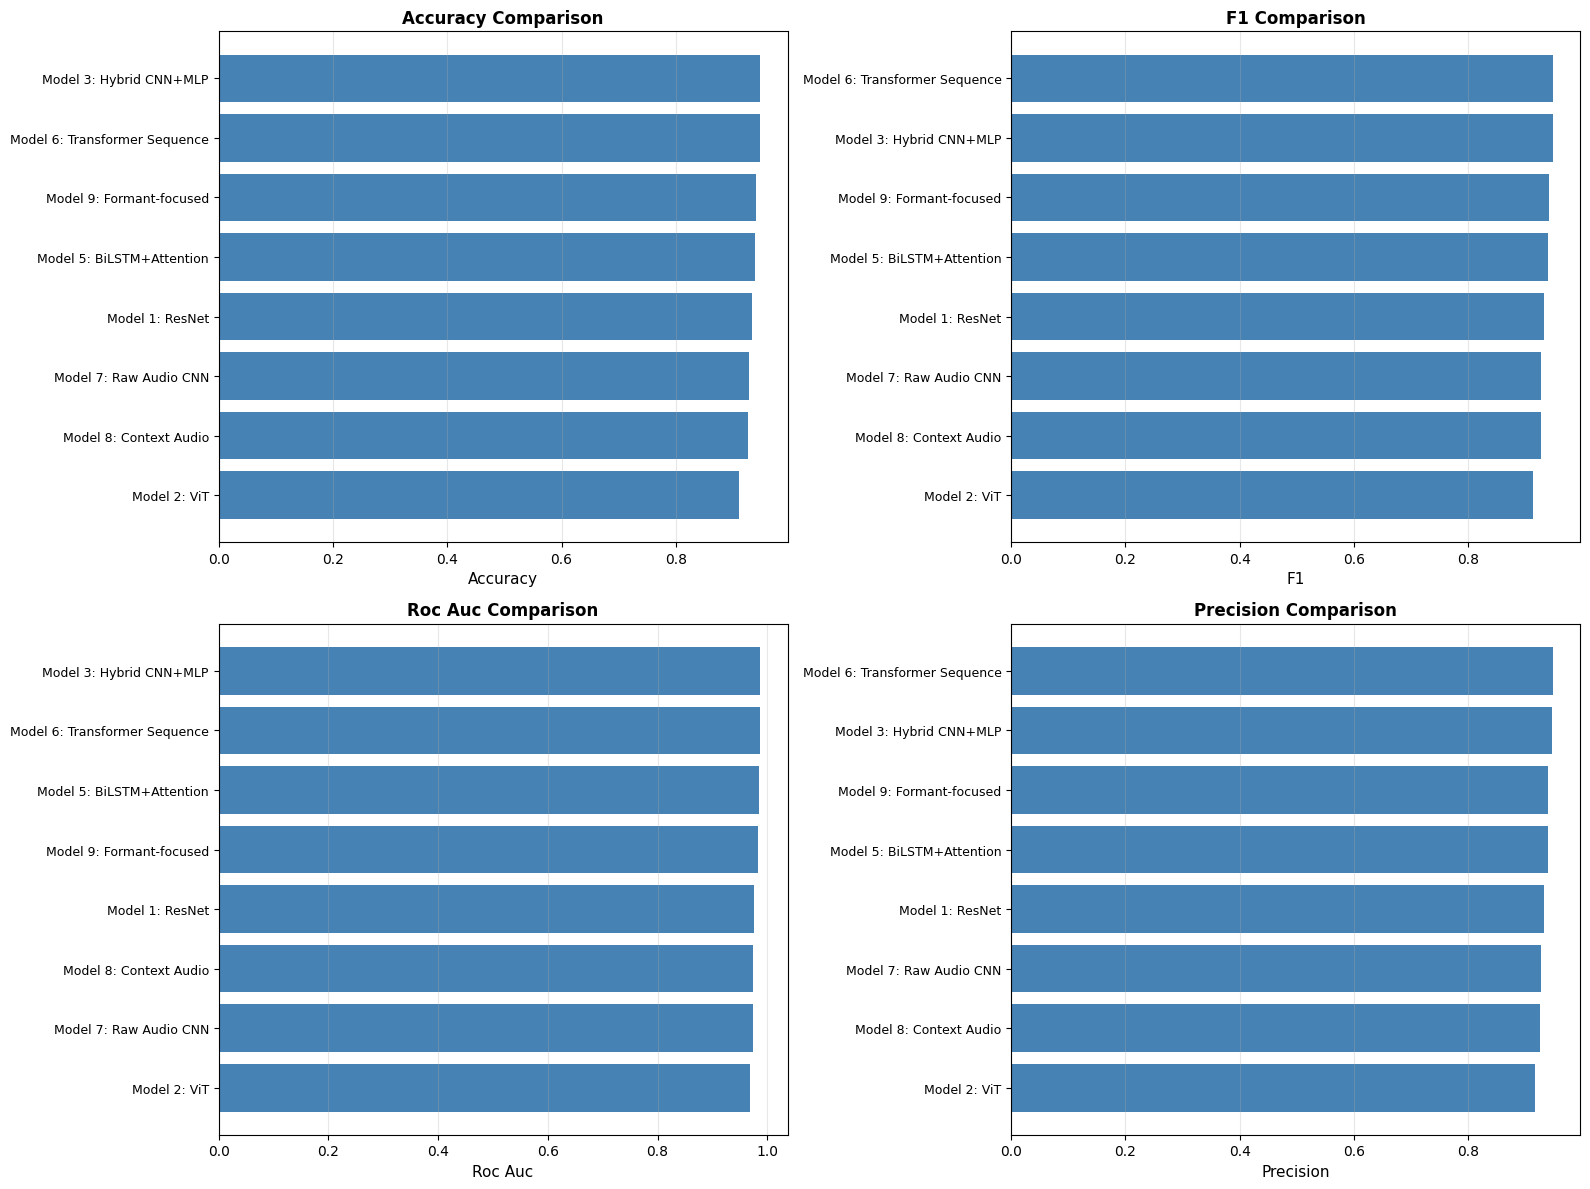

Metrics comparison saved.


In [10]:
# 2. Metrics Comparison Bar Chart
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

metrics_to_plot = ['accuracy', 'f1', 'roc_auc', 'precision']
for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    sorted_df = results_df.sort_values(metric, ascending=True)
    ax.barh(range(len(sorted_df)), sorted_df[metric], color='steelblue')
    ax.set_yticks(range(len(sorted_df)))
    ax.set_yticklabels(sorted_df['model_name'], fontsize=9)
    ax.set_xlabel(metric.replace('_', ' ').title(), fontsize=11)
    ax.set_title(f'{metric.replace("_", " ").title()} Comparison', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(COMPARISON_DIR / 'metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Metrics comparison saved.")

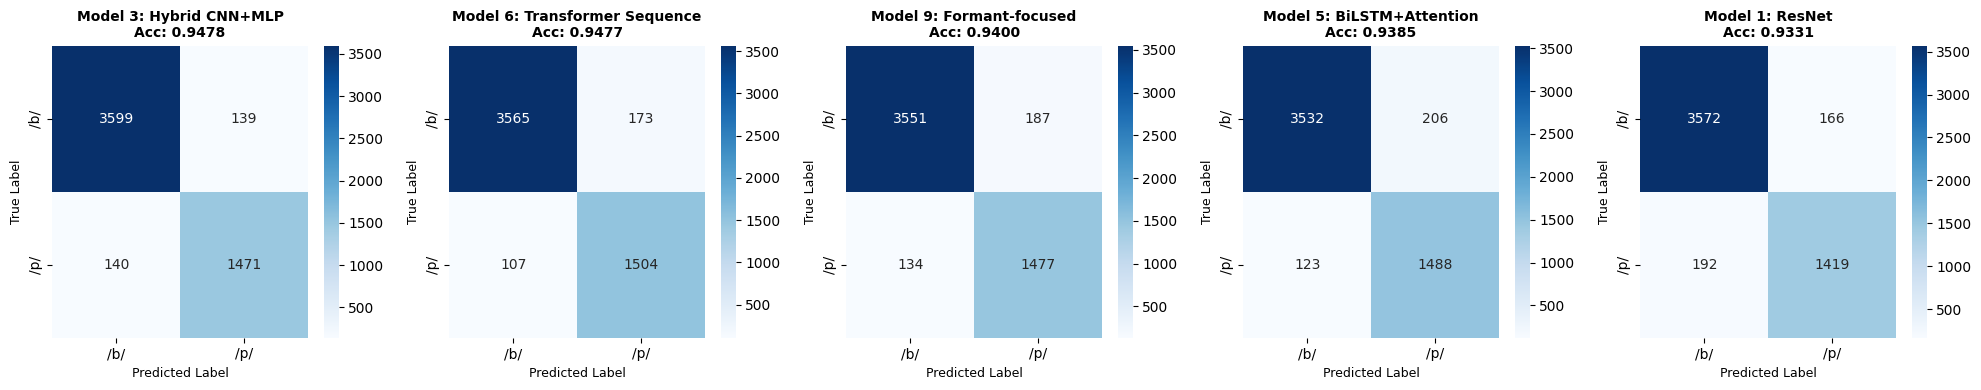

Confusion matrices saved.


In [11]:
# 3. Confusion Matrices for Top 5 Models
top_5 = results_df.nlargest(5, 'accuracy')

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx, (_, row) in enumerate(top_5.iterrows()):
    ax = axes[idx]
    name = row['model_name']
    cm = np.array(all_test_metrics[name]['metrics']['confusion_matrix'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
               xticklabels=['/b/', '/p/'], yticklabels=['/b/', '/p/'])
    ax.set_title(f"{name}\nAcc: {row['accuracy']:.4f}", fontsize=10, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=9)
    ax.set_xlabel('Predicted Label', fontsize=9)

plt.tight_layout()
plt.savefig(COMPARISON_DIR / 'confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()
print("Confusion matrices saved.")

## Generate Comparison Report

In [12]:
# Generate markdown report
report_lines = [
    "# B-P Phoneme Classification - DL Models Comparison Report",
    "",
    f"Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}",
    "",
    "## Summary",
    f"Total models evaluated: {len(results_df)}",
    "",
    "## Top 5 Models by Accuracy",
    ""
]

for rank, (_, row) in enumerate(results_df.nlargest(5, 'accuracy').iterrows(), 1):
    report_lines.extend([
        f"### Rank {rank}: {row['model_name']}",
        f"- **Accuracy**: {row['accuracy']:.4f}",
        f"- **F1-score**: {row['f1']:.4f}",
        f"- **ROC-AUC**: {row['roc_auc']:.4f}",
        f"- **Precision**: {row['precision']:.4f}",
        f"- **Recall**: {row['recall']:.4f}",
        f"- **Precision (/b/)**: {row['precision_b']:.4f}",
        f"- **Precision (/p/)**: {row['precision_p']:.4f}",
        f"- **Recall (/b/)**: {row['recall_b']:.4f}",
        f"- **Recall (/p/)**: {row['recall_p']:.4f}",
        ""
    ])

report_lines.extend([
    "## Complete Results Table",
    "",
    "| Model | Accuracy | F1 | ROC-AUC | Precision | Recall |",
    "|-------|----------|----|---------|-----------|--------|"
])

for _, row in results_df.iterrows():
    report_lines.append(
        f"| {row['model_name']} | {row['accuracy']:.4f} | {row['f1']:.4f} | {row['roc_auc']:.4f} | {row['precision']:.4f} | {row['recall']:.4f} |"
    )

report_lines.extend([
    "",
    "## Recommendations",
    "",
    f"**Best overall model**: {results_df.iloc[0]['model_name']} (Accuracy: {results_df.iloc[0]['accuracy']:.4f})",
    "",
    f"**Best F1-score**: {results_df.nlargest(1, 'f1').iloc[0]['model_name']} (F1: {results_df.nlargest(1, 'f1').iloc[0]['f1']:.4f})",
    "",
    f"**Best ROC-AUC**: {results_df.nlargest(1, 'roc_auc').iloc[0]['model_name']} (ROC-AUC: {results_df.nlargest(1, 'roc_auc').iloc[0]['roc_auc']:.4f})",
    "",
    "## Files Generated",
    f"- Comparison table: `{COMPARISON_DIR / 'comparison_table.csv'}`",
    f"- ROC curves: `{COMPARISON_DIR / 'roc_curves.png'}`",
    f"- Metrics comparison: `{COMPARISON_DIR / 'metrics_comparison.png'}`",
    f"- Confusion matrices: `{COMPARISON_DIR / 'confusion_matrices.png'}`",
    ""
])

# Save report
report_path = COMPARISON_DIR / 'comparison_report.md'
with open(report_path, 'w', encoding='utf-8') as f:
    f.write('\n'.join(report_lines))

print(f"\nReport saved to {report_path}")
print(f"\nTop 3 models:")
for i, (_, row) in enumerate(results_df.nlargest(3, 'accuracy').iterrows(), 1):
    print(f"{i}. {row['model_name']}: Acc={row['accuracy']:.4f}, F1={row['f1']:.4f}, ROC-AUC={row['roc_auc']:.4f}")


Report saved to /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dl_models/comparison/comparison_report.md

Top 3 models:
1. Model 3: Hybrid CNN+MLP: Acc=0.9478, F1=0.9478, ROC-AUC=0.9875
2. Model 6: Transformer Sequence: Acc=0.9477, F1=0.9479, ROC-AUC=0.9867
3. Model 9: Formant-focused: Acc=0.9400, F1=0.9403, ROC-AUC=0.9840
